In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

sys.path.append("/hpc/home/ps325/projects/gaston-velorama/src/gaston-base")

import gaston


import seaborn as sns
import math

In [2]:
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

In [3]:
CDATADIR = "gaston-base/gaston/docs/notebooks/tutorials/"
counts_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load(CDATADIR + 'cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

In [4]:
num_dims=8 # 2 * number of clusters
penalty=10 # may need to increase if this is too small

glmpca_res=glmpca.glmpca(counts_mat.T, num_dims, fam="poi", penalty=penalty, verbose=True)
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save(CDATADIR + 'cerebellum_data/glmpca.npy', A)

Iteration: 0 | deviance=2.4128E+7
Iteration: 1 | deviance=2.4128E+7
Iteration: 2 | deviance=2.3946E+7
Iteration: 3 | deviance=2.2859E+7
Iteration: 4 | deviance=2.2505E+7
Iteration: 5 | deviance=2.2373E+7
Iteration: 6 | deviance=2.2306E+7
Iteration: 7 | deviance=2.2271E+7
Iteration: 8 | deviance=2.2250E+7
Iteration: 9 | deviance=2.2236E+7
Iteration: 10 | deviance=2.2225E+7
Iteration: 11 | deviance=2.2217E+7
Iteration: 12 | deviance=2.2210E+7
Iteration: 13 | deviance=2.2205E+7
Iteration: 14 | deviance=2.2201E+7
Iteration: 15 | deviance=2.2197E+7
Iteration: 16 | deviance=2.2194E+7
Iteration: 17 | deviance=2.2191E+7


In [5]:
A = np.load(CDATADIR + 'cerebellum_data/glmpca.npy')

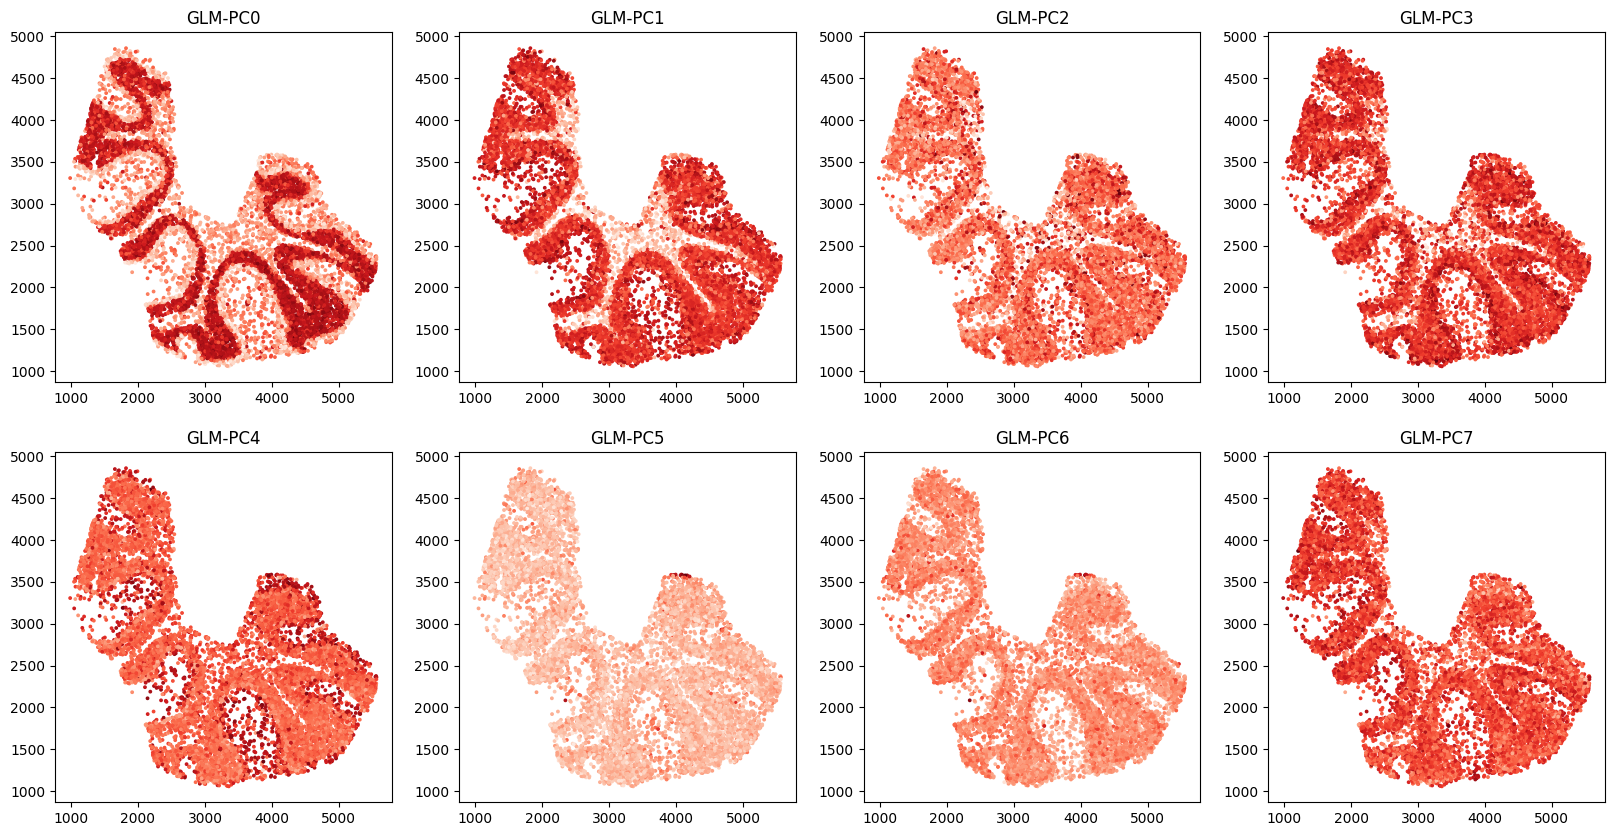

In [6]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

In [7]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load(CDATADIR + 'cerebellum_data/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [8]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=0

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

In [9]:
# gaston_model, A, S= process_NN_output.process_files('cerebellum_tutorial_outputs')
gaston_model, A, S= process_NN_output.process_files(CDATADIR + 'cerebellum_data/reproduce_cerebellum') # TO MATCH PAPER FIGURES

# may need to re-load counts_mat, coords_mat, gene_labels from previous step
counts_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load(CDATADIR + 'cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes


best model: gaston-base/gaston/docs/notebooks/tutorials/cerebellum_data/reproduce_cerebellum/seed19


In [10]:
num_layers=4
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# DATASET-SPECIFIC: so domains are ordered oligodendrocyte to molecular, with increasing isodepth
gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels

In [11]:
scale_factor=64/100 # since 64 pixels = 100 microns in slide-seq image

# WITH VISUALIZATION
# gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
#                                  q_vals=[0.2, 0.05, 0.15, 0.3], visualize=True, figsize=(12,12),num_rows=2)

# WITHOUT
gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
                                 q_vals=[0.2, 0.05, 0.15, 0.3], scale_factor=scale_factor)

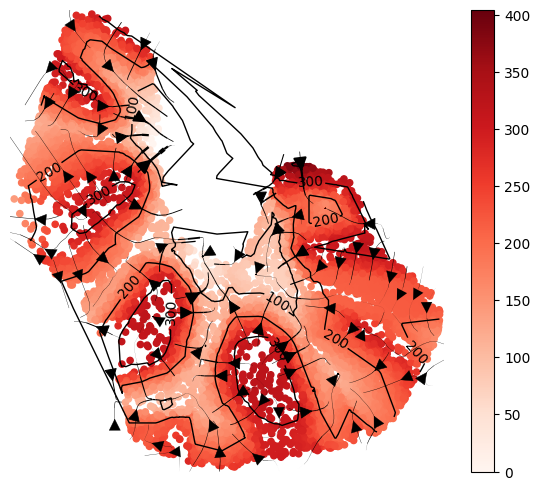

In [12]:
show_streamlines=True
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, cmap='Reds')

Astrocytes           True
Bergmann            False
Candelabrum          True
Choroid              True
Endothelial          True
Ependymal            True
Fibroblast           True
Globular             True
Golgi                True
Granule              True
Lugaro               True
MLI1                 True
MLI2                False
Macrophages          True
Microglia            True
Oligodendrocytes     True
Polydendrocytes      True
Purkinje             True
UBCs                 True
dtype: bool


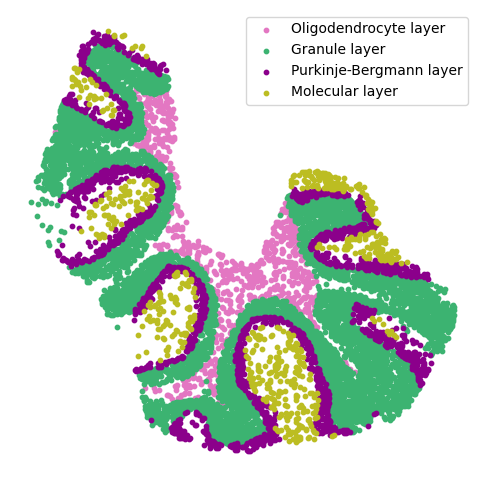

In [13]:
labels=['Oligodendrocyte layer', 'Granule layer', 'Purkinje-Bergmann layer', 'Molecular layer']

# WITHOUT CUSTOM COLORS
# cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), colors=None, 
#                                color_palette=plt.cm.Dark2, s=10,labels=labels,lgd=True)

# TO PLOT WITH CUSTOM COLORS:
domain_colors=['C6', 'mediumseagreen', 'darkmagenta', 'C8']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
                               colors=domain_colors, s=10,labels=labels,lgd=True)


cell_type_df=pd.read_csv(CDATADIR + 'cerebellum_data/cell_type_df.csv', index_col=0)
cell_type_df.head()
cell_type_mod_df = cell_type_df.copy()
cell_type_mod_df['Cell_Type'] = cell_type_mod_df.idxmax(axis=1)
cell_type_mod_df = cell_type_mod_df[['Cell_Type']]
cell_type_mod_df.tail()

print((cell_type_df.iloc[0] == cell_type_df.iloc[1]))

In [54]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import time

def create_knn(kmin, kstep, plots, plot): #input of minimum k, k-step, # of k-NNs to make, and bool plot results
    a_list = [] #init list of accuracies
    if plot:
        # Set a larger figure size based on the number of plots
        plt.figure(figsize=(4 * min(plots, 4), 4 * ((plots // 4) + 1)))

    for k in range(kmin, kmin+kstep*plots, kstep): #iterate with various k
        start = time.perf_counter()
        points = coords_mat #points to construct graph
        matches = 0 #number of neighbors that are same cell type
        total = 0 #total connections formed
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points) #create k-NN
        distances, indices = nbrs.kneighbors(points)
        position = (k - kmin)//kstep + 1 #nth iteration
        
        if plot:
            ax = plt.subplot(plots // 4 + 1, min(plots, 4), position)
            plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points', s=3)
            plt.xlim(1250, 3300)
            plt.ylim(1250, 3300)
        for i in range(points.shape[0]):
            for j in indices[i]:
                if i != j:  # Avoid self-connections
                    if plot:
                        plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'k-', alpha=0.6)
                    if (cell_type_df.iloc[i] == cell_type_df.iloc[j])['Cell_Type']: #determine if neighbors are same cell type
                        matches+=1
                    total+=1
        if plot:
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.title(f'{k}-Nearest Neighbors Graph')
        
        accuracy = (matches/total)*100 #calculate proportion of neighbors that are same cell type
        a_list.append(accuracy) #add to list
        end = time.perf_counter()
        print(f"Accuracy for {k}-Nearest Neighbors is {accuracy}% in {end - start:0.4f} seconds")

    if plot:
        plt.tight_layout()
        plt.show()
    
    x_values = np.arange(kmin, kmin+kstep*plots, kstep) #graph accuracy vs k
    plt.plot(x_values, a_list)
    plt.title('Accuracies vs K')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    
    return x_values,a_list

In [115]:
import pandas as pd  # Importing the Pandas library

def create_knn_mod(kmin, kstep, plots, plot):
    a_list = []  # Initialize list of accuracies

    if plot:
        # Set a larger figure size based on the number of plots
        # plt.figure(figsize=(4 * min(plots, 4), 4 * ((plots // 4) + 1)))
        
        colors = plt.get_cmap('Blues')  # Get the colormap
        plt.figure(figsize=(20, 20))
        ax = plt.gca()  # Get the current Axes instance


    kmax = kmin + kstep * (plots - 1)
    points = coords_mat  # Points to construct graph

    # Fit the model once for the maximum number of neighbors
    nbrs = NearestNeighbors(n_neighbors=kmax, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    
    matches = 0  # Number of neighbors that are same cell type
    total = 0  # Total connections formed
    
    prev_k = 0
    for k in range(kmin, kmax + kstep, kstep):  # Iterate with various k
        start = time.perf_counter()

        position = (k - kmin) // kstep + 1  # nth iteration
        
        if plot:
            # ax = plt.subplot(plots // 4 + 1, min(plots, 4), position)
            plt.scatter(points[:, 0], points[:, 1], c='black', label='Points', s=3)

        for i in range(points.shape[0]):
            # Use only the first k indices for this iteration
            relevant_indices = indices[i, prev_k:k]
            for j in relevant_indices:
                if i != j:  # Avoid self-connections
                    if plot:
                        color = colors(0.5 + 0.5 * (kmax - k) / (kmax - kmin))
                        ax.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], color=color, alpha=0.6)
                    if ((cell_type_df.iloc[i] == cell_type_df.iloc[j])['Cell_Type']):  # Determine if neighbors are same cell type
                        matches += 1
                    total += 1
                    
        accuracy = (matches / total) * 100  # Calculate proportion of neighbors that are same cell type
        a_list.append(accuracy)  # Add to list
        end = time.perf_counter()
        prev_k = k
        print(f"Accuracy for {k}-Nearest Neighbors is {accuracy}% in {end - start:0.4f} seconds")

    if plot:
        plt.tight_layout()
        plt.show()
    
    x_values = np.arange(kmin, kmax + kstep, kstep)  # Graph accuracy vs k
    plt.plot(x_values, a_list)
    plt.title('Accuracies vs K')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    
    return x_values, a_list

# The function call is commented out to prevent execution in this environment
# create_knn(2, 1, 5, True)


Accuracy for 2-Nearest Neighbors is 62.58387581372058% in 0.9367 seconds
Accuracy for 18-Nearest Neighbors is 54.11057763115261% in 14.3810 seconds
Accuracy for 34-Nearest Neighbors is 51.2447459067389% in 12.8568 seconds
Accuracy for 50-Nearest Neighbors is 49.26716605520526% in 12.8903 seconds
Accuracy for 66-Nearest Neighbors is 47.78198066330265% in 13.1528 seconds
Accuracy for 82-Nearest Neighbors is 46.60991487230846% in 13.0894 seconds
Accuracy for 98-Nearest Neighbors is 45.61398799229773% in 12.9937 seconds
Accuracy for 114-Nearest Neighbors is 44.74065079920766% in 13.0502 seconds
Accuracy for 130-Nearest Neighbors is 44.00701827935702% in 13.0738 seconds
Accuracy for 146-Nearest Neighbors is 43.391293837307686% in 13.3974 seconds
Accuracy for 162-Nearest Neighbors is 42.85832475421206% in 14.7821 seconds
Accuracy for 178-Nearest Neighbors is 42.395797085458696% in 14.7367 seconds
Accuracy for 194-Nearest Neighbors is 41.986866309827434% in 14.3182 seconds
Accuracy for 210-Ne

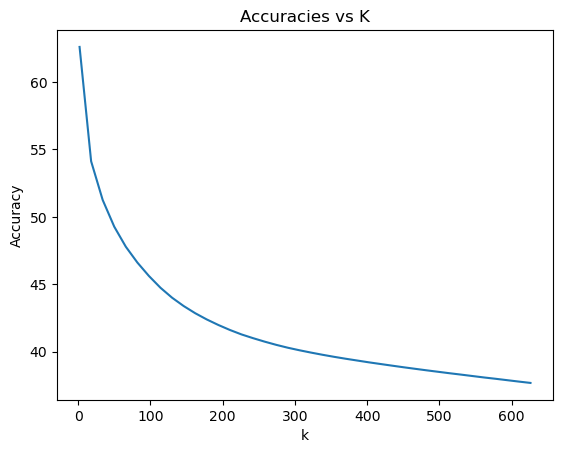

In [121]:
x, y = create_knn_mod(2, 16, 40, False)

130


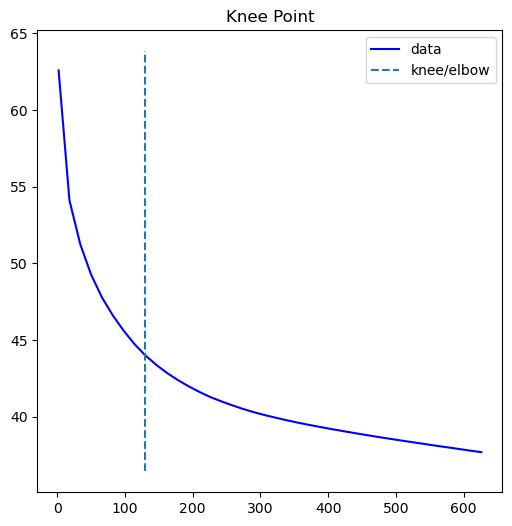

In [122]:
import kneed
from kneed import DataGenerator, KneeLocator


kneedle = KneeLocator(x, y, S=1.0, curve="convex", direction="decreasing")
print(round(kneedle.knee, 3))
kneedle.plot_knee()

In [22]:
def dag_orient_edges(adjacency_matrix,isodepth):

	A = adjacency_matrix.astype(bool).astype(float)
	D = -1*np.sign(isodepth[:,None] - isodepth).T
	D = (D == 1).astype(float)
	D = (A.toarray()*D).astype(bool).astype(float)

	return D

In [34]:
def infer_knngraph_isodepth(gaston_model, A, S, coords_mat, cell_type_df, num_layers=4, scale_factor=64/100,
                            n_neighbors=7,flip=False, plot=True):
    
    start = time.perf_counter()
    mod = 1
    if flip:
        mod = -1
        
    gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)
    gaston_isodepth=np.max(gaston_isodepth) - gaston_isodepth
    gaston_isodepth=mod*isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
                                 q_vals=[0.2, 0.05, 0.15, 0.3], scale_factor=scale_factor)
    points = coords_mat #points to construct graph
    matches = 0 #number of neighbors that are same cell type
    total = 0 #total connections formed
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(points) #create k-NN
    distances, indices = nbrs.kneighbors(points)

    if plot:
        plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points', s=3)
        plt.xlim(1250, 3300)
        plt.ylim(1250, 3300)
    for i in range(points.shape[0]):
        for j in indices[i]:
            if i != j:  # Avoid self-connections
                if plot:
                    plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'k-', alpha=0.6)
                if (cell_type_df.iloc[i] == cell_type_df.iloc[j]).iloc[0]: #determine if neighbors are same cell type
                    matches+=1
                total+=1
    if plot:
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(f'{n_neighbors}-Nearest Neighbors Graph')

    accuracy = (matches/total)*100 #calculate proportion of neighbors that are same cell type
    end = time.perf_counter()
    print(f"Accuracy for {n_neighbors}-Nearest Neighbors is {accuracy}% in {end - start:0.4f} seconds")
    
    knn_graph = nbrs.kneighbors_graph(mode='connectivity').astype(float)

    return gaston_isodepth,knn_graph

In [35]:
def construct_dag_isodepth(gaston_model, A, S, coords_mat, cell_type_df, num_layers=4, scale_factor=64/100,
                           n_neighbors=7,flip=False, plot=True):
	
	"""Constructs the adjacency matrix for a DAG using pseudotime.
	Parameters
	----------
	joint_feature_embeddings: 'numpy.ndarray' (default: None)
		Matrix of low dimensional embeddings with rows corresponding
		to observations and columns corresponding to feature embeddings
		for constructing a DAG if a custom DAG is not provided.
	iroot: 'int' (default: None)
		Index of root cell for inferring pseudotime for constructing a DAG 
		if a custom DAG is not provided.
	n_neighbors: 'int' (default: 15)
		Number of nearest neighbors to use in constructing a k-nearest
		neighbor graph for constructing a DAG if a custom DAG is not provided.
	pseudotime_algo: {'dpt','palantir'} 
		Pseudotime algorithm to use for constructing a DAG if a custom DAG 
		is not provided. 'dpt' and 'palantir' perform the diffusion pseudotime
		(Haghverdi et al., 2016) and Palantir (Setty et al., 2019) algorithms, 
		respectively.
	precomputed_pseudotime: 'numpy.ndarray' or List (default: None)
		Precomputed pseudotime values for all cells.
	"""

	isodepth,knn_graph = infer_knngraph_isodepth(gaston_model, A, S, coords_mat, cell_type_df,
                                                 num_layers, n_neighbors, flip, plot)
    
	dag_adjacency_matrix = dag_orient_edges(knn_graph,isodepth)

	return dag_adjacency_matrix


Accuracy for 7-Nearest Neighbors is 58.050408946753464% in 37.9741 seconds
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


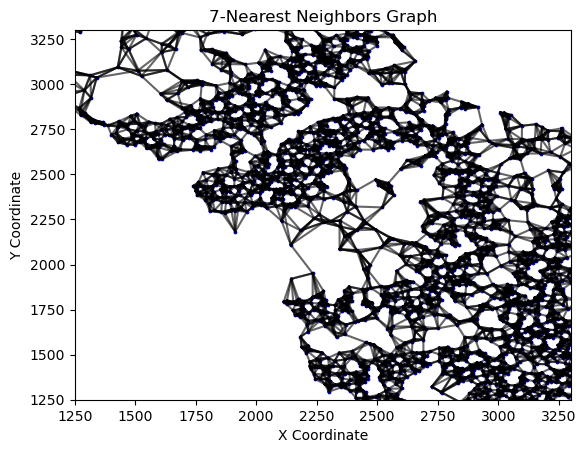

In [36]:



dag_adjacency_matrix = construct_dag_isodepth(gaston_model, A, S, coords_mat, cell_type_df, 4, 7, False, True)
print(dag_adjacency_matrix)

In [12]:
# Cell types for which to compute cell type-specific expression functions.
ct_list=['Oligodendrocytes', 'Granule', 'Bergmann', 'Purkinje', 'MLI1', 'MLI2']
# ct_list=[] # FOR SPEED, if you don't care about cell type specific effects or don't have cell type dict

# if you want to get rid of warnings
import warnings
warnings.filterwarnings("ignore")

# Piecewise linear fit parameters
t=0.1 # set slope=0 if LLR p-value > 0.1
umi_threshold=500 # only compute fit for genes with total UMI > 500
zero_fit_threshold=75 # only compute fit for (gene, domain) where gene has at least 75 UMIs in domain

pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth, 
                                          cell_type_df, ct_list, zero_fit_threshold=zero_fit_threshold,
                                        t=t,umi_threshold=umi_threshold,
                                       isodepth_mult_factor=0.1)

binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
                         cell_type_df, gene_labels, num_bins_per_domain=[5,10,5,5], umi_threshold=500)
    
binning_output['gene_labels_idx'][ np.argsort(np.max(np.abs(pw_fit_dict['all_cell_types'][0]),1)) ][::-1][:100]

Poisson regression for ALL cell types


100%|██████████| 2193/2193 [00:28<00:00, 77.44it/s]


Poisson regression for cell type: Oligodendrocytes


100%|██████████| 2193/2193 [00:21<00:00, 100.09it/s]


Poisson regression for cell type: Granule


100%|██████████| 2193/2193 [00:25<00:00, 85.04it/s]


Poisson regression for cell type: Bergmann


100%|██████████| 2193/2193 [00:17<00:00, 125.31it/s]


Poisson regression for cell type: Purkinje


100%|██████████| 2193/2193 [00:16<00:00, 134.38it/s]


Poisson regression for cell type: MLI1


100%|██████████| 2193/2193 [00:17<00:00, 124.54it/s]


Poisson regression for cell type: MLI2


100%|██████████| 2193/2193 [00:17<00:00, 126.63it/s]


array(['Gdf10', 'Car8', 'Ppp1r17', 'Calb1', 'Prkcg', 'Rbfox3', 'Ntrk3',
       'Gria1', 'Rgs8', 'Arl4c', 'Slc1a6', 'Itpr1', 'Prkg1', 'Sez6l',
       'Nrep', 'Cdh18', 'Slc1a3', 'Cbln3', 'Syt1', 'Dlg2', 'Pcp4',
       'Homer3', 'Cadps2', 'Dock9', 'Ptprr', 'Cbln1', 'Cntn4', 'Galnt13',
       'Kctd12', 'Dpp10', 'Pvalb', 'D430041D05Rik', 'Myt1l', 'Dgkg',
       'Ptprm', 'Mybpc1', 'Gpr37l1', 'Kirrel3', 'Paxbp1', 'Mtcl1',
       'Frmd5', 'Cnr1', 'Snhg11', 'Prmt8', 'Slc1a2', 'Arhgap26', 'Auts2',
       'Garnl3', 'Zdhhc14', 'Cabp1', 'Dner', 'Chn2', 'Cygb', 'Gng13',
       'Kcnab1', 'Id2', 'Kcnd2', 'Ubash3b', 'Mctp1', 'Camk2n1', 'Snap25',
       'Slc24a2', 'Brinp1', 'Atl2', 'Id4', 'Sparc', 'Anks1b', 'S100b',
       'Pde4d', 'Clstn1', 'Penk', 'Dmd', 'Eml5', 'Kif5a', 'Gpc6',
       'Zfp106', 'Fam107a', 'Scn2a1', 'Pcp2', 'Stmn4', 'Fgf14', 'Coro2b',
       'Sybu', 'Fam107b', 'Mir124a-1hg', 'Map1a', 'Ebf1', 'Gria3',
       'Inpp4b', 'mt-Rnr2', 'mt-Rnr1', 'Thsd7a', 'Gabrb3', 'Nptx1',
       'Megf11', 

In [19]:
q=0.9 # use 0.9 quantile for slopes, discontinuities
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)
print(cont_genes_layer)

defaultdict(<class 'list'>, {'1500009C09Rik': [1], '2610203C20Rik': [1], '4930402H24Rik': [0], '5031439G07Rik': [1], 'A330023F24Rik': [1], 'Abca2': [1], 'Abhd16a': [2], 'Ablim2': [2], 'Abr': [1], 'Aco2': [2, 3], 'Acot7': [3], 'Acsbg1': [1], 'Actb': [3], 'Acyp2': [1], 'Adam11': [2], 'Adam23': [2], 'Adgrl3': [1], 'Adrbk2': [2], 'Agpat4': [1], 'Ahcyl1': [1], 'Ahi1': [2], 'Aig1': [2], 'Airn': [1], 'Akirin2': [1], 'Aldh1a1': [2], 'Aldoc': [1, 3], 'Ank1': [2], 'Ank2': [3], 'Anks1b': [2, 3], 'Apba2': [2], 'Aplp1': [0], 'Apod': [0, 1], 'Apoe': [3], 'Appl2': [0], 'Arap2': [1], 'Arhgap23': [1], 'Arhgap26': [2], 'Arhgap5': [0], 'Arid1b': [2], 'Arl4c': [2, 3], 'Arrb1': [1, 2], 'Atl2': [1, 2], 'Atp1a2': [1, 3], 'Atp1a3': [3], 'Atp1b1': [1, 3], 'Atp2a2': [1], 'Atp2b1': [2], 'Atp5a1': [3], 'Atp5b': [0], 'Atp5g3': [0], 'Atp6v1b2': [3], 'Atrx': [3], 'Auts2': [2], 'Bcan': [1], 'Bcar1': [1, 2], 'Bin1': [1], 'Brinp1': [2], 'Cabp1': [2], 'Cacna1a': [2], 'Cacnb4': [2], 'Cacng2': [3], 'Cadps2': [2], 'Calb1':

In [18]:
a = len(discont_genes_layer.keys())
b = len(cont_genes_layer.keys())


469 499


In [28]:
def reg_list(file, pw_fit_dict, binning_output, q):
    with open(file, 'r') as file:
        tfs = file.readlines()
    tfs = [line.strip() for line in tfs]
    
    discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
    cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)
    
    genes = list(discont_genes_layer.keys()) + list(cont_genes_layer.keys())
    
    tf_set = set(tfs)
    gene_set = set(genes)
    
    reg_set = tf_set.intersection(gene_set)
    
    return reg_set

In [29]:
reg_set = reg_list('transcription_factors.txt', pw_fit_dict, binning_output, q)

In [30]:
print(reg_set)
print(len(reg_set))

{'Setbp1', 'Msra', 'Ywhae', 'Pura', 'Prnp', 'Ski', 'Nr1d2', 'Ubxn1', 'Ncoa1', 'Hspa5', 'Luzp2', 'Zic1', 'Gpd1', 'Zbtb20', 'Hdac8', 'Neurod1', 'Neurod2', 'Ncald', 'Stat2', 'Fez1', 'Celf4', 'Chd2', 'Git2', 'Rufy3', 'Id4', 'Id2', 'Etv1', 'Tcf4', 'Nr1d1', 'Tppp', 'Zeb2', 'Luzp1', 'En2', 'Ebf1', 'Dusp26', 'Zbtb18', 'Rora', 'Foxo3', 'Srrm3'}
39
